# AtCoder rating system

This is AtCoder rating system implementation. We are trying to compare it to CodeForces rating system and try to improve it - find the best parameters for this system.

## Imports

In [2]:
from database import Database, LoadDatabase
import pickle, time, math, bz2, os
from numba import njit, vectorize
import matplotlib.pyplot as plt
import numpy as np

os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'

## AtCoder Rating functions

In [92]:
# helpers
def prepare_data(db):
    CALCS_FILE = "calcs.pickle.bz2"    
    # if calculated and save before, load it from file
    if os.path.exists(CALCS_FILE):
        with bz2.BZ2File(CALCS_FILE, "r") as infile:
            print("Starting loading calcs file ...")
            ret = pickle.load(infile)
            print("File read.")
    else:
        print("Starting calcs ...")
        # load database
        db = LoadDatabase()

        # collect all handles in all standings
        all_handles = set()
        for standings in db.standings.values():
            for handle in standings.index:
                all_handles.add(handle)

        # create to way mappings (id, handle)
        handle_to_id = {handle: i for i, handle in enumerate(all_handles)}
        id_to_handle = {i: handle for handle, i in handle_to_id.items()}

        # sort standings by startTime
        sorted_standings = [(k, v) for k, v in sorted(db.standings.items(), key=lambda x: db.contests.loc[x[0]].startTime)]

        # merge handles, ranks and standings length into flat array
        handle_ids_merged = []
        ranks_merged = []
        standings_lengths_merged = []

        for c_id, standings in sorted_standings:
            standings = standings.sort_values("rank")
            for handle in standings.index:
                handle_ids_merged.append(handle_to_id[handle])
                ranks_merged.append(standings["rank"][handle])
            standings_lengths_merged.append(len(standings))

        # convert them to numpy array
        handle_ids = np.array(handle_ids_merged, dtype=np.int32)
        ranks = np.array(ranks_merged, dtype=np.int32)
        standings_lens = np.array(standings_lengths_merged, dtype=np.int32)
        user_contest_cnt = np.bincount(handle_ids)
    
        with bz2.BZ2File(CALCS_FILE, "w") as outfile:
            ret = (handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt)
            pickle.dump(ret, outfile)

        print("Calcs ended.")
        
    return ret

def get_first_K_contests(K, handle_ids, ranks, standings_lens, user_contest_cnt):
    if K == -1:
        return handle_ids, ranks, standings_lens, user_contest_cnt
    K_standings_len = np.sum(standings_lens[:K])
    K_handle_ids = handle_ids[:K_standings_len]
    K_ranks = ranks[:K_standings_len]
    K_standings_lens = standings_lens[:K]
    K_user_contest_cnt = np.bincount(K_handle_ids)
    return K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt


# Additional return value of AtCoderRatingSystem, which has all calculations, meaningful variables (pretty specific)
class Result:
    def __init__(self, consider, handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens,
                 user_contest_cnt, nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks,
                 Is, errors, avg_ranking_error_dict):
        self.consider = consider
        self.handle_to_id = handle_to_id
        self.id_to_handle = id_to_handle
        self.sorted_standings = sorted_standings
        self.handle_ids = handle_ids
        self.ranks = ranks
        self.standings_lens = standings_lens
        self.user_contest_cnt = user_contest_cnt
        self.nums = nums
        self.dens = dens
        self.aperfs = aperfs
        self.perfs = perfs
        self.ratings = ratings
        self.offsets = offsets
        self.local_offsets = local_offsets
        self.current_ranks = current_ranks
        self.Is = Is
        self.errors = errors
        self.avg_ranking_error_dict = avg_ranking_error_dict
        
    def get_cf_ratings(self, handle):
        ratings = []
        if self.consider == -1:
            trimmed_standings = self.sorted_standings
        else:
            trimmed_standings = self.sorted_standings[:self.consider]
        for contest_id, standings in trimmed_standings:
            if handle in standings.index:
                ratings.append(standings.loc[handle]["oldRating"])
        return ratings
        
    def get_random_user(self, threshold=10):
        all_ids = np.arange(len(self.user_contest_cnt))
        mask = self.user_contest_cnt >= threshold
        handle_id = np.random.choice(all_ids[mask])
        return self.id_to_handle[handle_id]
    
    def plot_user(self, handle, verbose=False):
        handle_id = self.handle_to_id[handle]
        contest_cnt = self.user_contest_cnt[handle_id]
        user_offset = self.offsets[handle_id]
        print(contest_cnt, self.local_offsets[handle_id])
        assert contest_cnt == self.local_offsets[handle_id]
        
        perfs = self.perfs[user_offset:user_offset+contest_cnt]
        atcoder_ratings = self.ratings[user_offset:user_offset+contest_cnt]
        cf_ratings = self.get_cf_ratings(handle)
        
        assert contest_cnt == len(cf_ratings)
        print("number of contests", contest_cnt)
        
        if verbose:
            print("perfs", perfs)
            print("aperf", self.aperfs[handle_id])
            print("num", self.nums[handle_id])
            print("den", self.dens[handle_id])
            
        xs = np.arange(contest_cnt)
        plt.figure(figsize=(15, 8))
        plt.plot(xs, atcoder_ratings, label="AtCoder")
        plt.plot(xs, cf_ratings, label="CodeForces")
#         plt.plot(xs, perfs, label="AtCoder Perfs")
        plt.title(handle)
        plt.legend()
        plt.show()
        
# actual, main function
def AtCoderRatingSystem(db, err_fun=None,
                        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
                        consider=50, verbose=False, **kwargs):
    
    CENTER = 1200
    RATEDBOUND = np.inf
    
    @njit(fastmath=True)
    def atcoder_calculate(handle_ids, ranks, standings_lens, user_contest_cnt,
                          verbose=True):
        user_cnt = len(user_contest_cnt)
        standings_cnt = len(standings_lens)
        history_cnt = len(handle_ids)

        def g(x):
            return np.power(g_base, x / g_power_div)

        def ginv(y):
            return g_power_div * np.log(y) / np.log(g_base)

        # AtCoder stuff
        ranks = ranks.copy().astype(np.float64)
        nums = np.zeros(user_cnt, dtype=np.float64)
        dens = np.zeros(user_cnt, dtype=np.float64)
        aperfs = np.full(user_cnt, CENTER, dtype=np.float64)
        perfs = np.empty(history_cnt, dtype=np.float64)
        ratings = np.zeros(history_cnt, dtype=np.float64)
        offsets = np.cumsum(user_contest_cnt) - user_contest_cnt
        local_offsets = np.zeros(user_cnt, dtype=np.int32)
        current_ranks = np.empty_like(ranks, dtype=np.float64)

        # parallel binsearch stuff
        ls = np.empty(np.max(standings_lens), dtype=np.float64)
        rs = np.empty(np.max(standings_lens), dtype=np.float64)
        cnts = np.empty(np.max(standings_lens), dtype=np.int32)
        handles = np.empty(np.max(standings_lens), dtype=np.int32)
        ls_next = np.empty_like(ls)
        rs_next = np.empty_like(rs)
        cnts_next = np.empty_like(cnts)
        handle_to_rank = np.empty(user_cnt, dtype=np.int32)

        standings_offset = 0
        standings_left = len(standings_lens)

        for i in range(standings_cnt):
            if verbose:
                print("Standings left:", standings_left)
            standings_left -= 1
            standings_len = standings_lens[i]

            # fix ranks
            j = 0
            while j < standings_len:
                rank = ranks[standings_offset + j]
                k = j
                while k + 1 < standings_len and ranks[standings_offset + k + 1] == rank:
                    k += 1
                ranks[j:k + 1] = (2 * rank + k - j) / 2
                j = k + 1

            # create handle -> rank mapping given current standings
            slice_l, slice_r = standings_offset, standings_offset + standings_len
            handle_to_rank[handle_ids[slice_l:slice_r]] = ranks[slice_l:slice_r]

            # prepare to parallel binsearch
            ls[0], rs[0] = 0, 5000
            cnts[0] = standings_len
            handles[:standings_len] = handle_ids[slice_l:slice_r]
            segs, segs_next = 1, 0
            handles_offset = 0
            max_iters = 80

            # do parallel binsearch
            for j in range(max_iters):
                updated = False

                for k in range(segs):
                    l, r = ls[k], rs[k]
                    cnt = cnts[k]

                    if (r - l) <= 1e-1:
                        ls_next[segs_next] = l
                        rs_next[segs_next] = r
                        cnts_next[segs_next] = cnt
                        handles_offset += cnt
                        segs_next += 1
                    else:
                        updated = True
                        m = (l + r) / 2

                        val = 0.0
                        for t in range(standings_len):
                            handle_id = handle_ids[standings_offset + t]
                            aperf = aperfs[handle_id]
                            val += 1 / (1 + np.power(binsearch_base, (m - aperf) / binsearch_power_div))

                        lit, rit = handles_offset, handles_offset + cnt - 1
                        lefts, rights = 0, 0
                        while lit < rit:
                            lhandle_id = handles[lit]
                            lrank = handle_to_rank[lhandle_id]
                            if val <= lrank - 0.5:
                                lit += 1
                                lefts += 1
                                continue

                            rhandle_id = handles[rit]
                            rrank = handle_to_rank[rhandle_id]
                            if val > rrank - 0.5:
                                rit -= 1
                                rights += 1
                                continue

                            lefts += 1
                            rights += 1
                            handles[lit], handles[rit] = handles[rit], handles[lit]
                            lit += 1
                            rit -= 1

                        if lit == rit:
                            handle_id = handles[lit]
                            rank = handle_to_rank[handle_id]
                            if val <= rank - 0.5:
                                lefts += 1
                            else:
                                rights += 1

                        if lefts > 0:
                            ls_next[segs_next] = l
                            rs_next[segs_next] = m
                            cnts_next[segs_next] = lefts
                            segs_next += 1

                        if rights > 0:
                            ls_next[segs_next] = m
                            rs_next[segs_next] = r
                            cnts_next[segs_next] = rights
                            segs_next += 1

                        handles_offset += cnt

                if not updated:
                    break

                segs = segs_next
                ls[:segs] = ls_next[:segs]
                rs[:segs] = rs_next[:segs]
                cnts[:segs] = cnts_next[:segs]
                segs_next = 0
                handles_offset = 0

            # calculate perfs, ratings, ... after parallel binsearch
            handles_offset = 0
            for j in range(segs):
                perf_base = ls[j]
                cnt = cnts[j]

                for k in range(cnt):
                    handle_id = handles[handles_offset + k]
                    offset = offsets[handle_id]
                    local_offset = local_offsets[handle_id]

                    if local_offset == 0:
                        perf = (perf_base - CENTER) * 1.5 + CENTER
                        ratings[offset + local_offset] = CENTER
                    else:
                        perf = perf_base
                        den = dens[handle_id]
                        last_sum = g(ratings[offset + local_offset - 1]) * den
                        rperf = min(perfs[offset + local_offset - 1], RATEDBOUND + 400)
                        ratings[offset + local_offset] = ginv((decay * (last_sum + g(rperf))) / (decay * (1 + den)))

                    perfs[offset + local_offset] = perf
                    nums[handle_id] = decay * (perf + nums[handle_id])
                    dens[handle_id] = decay * (1 + dens[handle_id])
                    aperfs[handle_id] = nums[handle_id] / dens[handle_id]

                handles_offset += cnt

            # move user ratings to one place
            for j in range(standings_len):
                handle_id = handle_ids[standings_offset + j]
                offset = offsets[handle_id]
                local_offset = local_offsets[handle_id]
                current_ranks[standings_offset + j] = ratings[offset + local_offset]
                local_offsets[handle_id] += 1

            standings_offset += standings_len

        return nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks

    @njit(fastmath=True)
    def calculate_errors(err_fun, standings_lens, ranks, current_ranks, Is, verbose=True):
        standings_cnt = len(standings_lens)
        current_ranks = current_ranks.copy()
        errors = np.empty(standings_cnt, dtype=np.float64)
        ranking_error = np.zeros(np.max(standings_lens) + 1, dtype=np.float64)
        ranking_error_cnt = np.zeros(np.max(standings_lens) + 1, dtype=np.int32)

        standings_offset = 0
        standings_left = standings_cnt

        for i in range(standings_cnt):
            if verbose:
                print("Standings left:", standings_left)
            standings_left -= 1
            standings_len = standings_lens[i]

            # replace ratings with ranks
            j = 0
            while j < standings_len:
                current_rank = current_ranks[Is[standings_offset + j]]
                k = j
                while k + 1 < standings_len and current_ranks[Is[standings_offset + k + 1]] == current_rank:
                    k += 1
                first = j + 1
                last = k + 1
                current_ranks[Is[standings_offset + j:standings_offset + k + 1]] = (first + last) / 2
                j = k + 1

            # calculate errors
            total_err = 0
            for j in range(standings_len):
                real_rank = ranks[standings_offset + j]
                expected_rank = current_ranks[standings_offset + j]
                err = err_fun(real_rank, expected_rank)
                ranking_error[int(real_rank)] += err
                ranking_error_cnt[int(real_rank)] += 1
                total_err += err
            errors[i] = total_err / standings_len

            standings_offset += standings_len
    
        avg_ranking_error = np.empty_like(ranking_error, dtype=np.float64)
        for i in range(len(ranking_error)):
            if ranking_error_cnt[i] == 0:
                avg_ranking_error[i] = ranking_error[i]
            else:
                avg_ranking_error[i] = ranking_error[i] / ranking_error_cnt[i]
        return errors, avg_ranking_error
    
    ################ actual function ################
    global handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt
    # get data in familiar form
    if not "handle_to_id" in globals():
        handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt = \
            prepare_data(db)
        
    # convert err_fun to list of jitted err funs
    try:
        iter(err_fun)
    except:
        err_fun = [err_fun]
    err_fun = list(map(njit(fastmath=True), err_fun))
    
    # compile (jit)
    compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt = \
        get_first_K_contests(5,  handle_ids, ranks, standings_lens, user_contest_cnt)
    atcoder_calculate(compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt,
                      verbose=False)

    # main calculations
    K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt = \
        get_first_K_contests(consider, handle_ids, ranks, standings_lens, user_contest_cnt)
    t = time.time()
    nums, dens, aperfs, perfs, ratings, offsets, local_offsets, current_ranks = \
        atcoder_calculate(K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt,
                          verbose=verbose)
    delta = time.time() - t
    print("Calculated in %02dm %02.2fs" % (delta // 60, delta % 60))
    
    # some assertions haven't killed anybody, yet
    for i in range(len(K_user_contest_cnt)):
        assert K_user_contest_cnt[i] == local_offsets[i]
        
    # sort ratings in all contests to calculate error rate (argsort forbidden in numba ??)
    Is = np.empty_like(current_ranks, dtype=np.int32)
    standings_offset = 0
    standings_cnt = len(K_standings_lens)

    for i in range(standings_cnt):
        standings_len = K_standings_lens[i]
        slice_l, slice_r = standings_offset, standings_offset + standings_len
        Is[slice_l:slice_r] = standings_offset + np.argsort(current_ranks[slice_l:slice_r])[::-1]
        standings_offset += standings_len
    
    # errors
    errors_dict = {}
    avg_ranking_error_dict = {}
    trimmed_sorted_standings = sorted_standings[:consider] if consider != -1 else sorted_standings
    for err_f in err_fun:
        errors, avg_ranking_error = \
            calculate_errors(err_f, K_standings_lens, ranks, current_ranks, Is, verbose=False)
        current_errors = {}
        for i, (contest_id, _) in enumerate(trimmed_sorted_standings):
            current_errors[contest_id] = errors[i]
        errors_dict[err_f.__name__] = current_errors
        avg_ranking_error_dict[err_f.__name__] = avg_ranking_error

    return errors_dict, Result(consider, handle_to_id, id_to_handle, sorted_standings, K_handle_ids,
                               K_ranks, K_standings_lens, K_user_contest_cnt, nums, dens, aperfs, perfs,
                               ratings, offsets, local_offsets, current_ranks, Is, errors, avg_ranking_error_dict)

## Error functions

In [244]:
# error functions
def sqrt_err(x, y):
    return np.sqrt(np.abs(x - y))

def linear_err(x, y):
    return np.abs(x - y)

def squared_err(x, y):
    return np.power(x - y, 2)

def log_err(x, y):
    return np.abs(np.log(x) - np.log(y))

all_err_funs = [sqrt_err, linear_err, log_err]
all_err_fun_names = [err_f.__name__ for err_f in all_err_funs]

## Function call example

In [23]:
db = LoadDatabase()

In [146]:
errors, results = AtCoderRatingSystem(db, 
        err_fun=all_err_funs,
        g_base=1.2, g_power_div=1400, binsearch_base=6, binsearch_power_div=400, decay=0.95,
        consider=-1, verbose=True)

Standings left: 989
Standings left: 988
Standings left: 987
Standings left: 986
Standings left: 985
Standings left: 984
Standings left: 983
Standings left: 982
Standings left: 981
Standings left: 980
Standings left: 979
Standings left: 978
Standings left: 977
Standings left: 976
Standings left: 975
Standings left: 974
Standings left: 973
Standings left: 972
Standings left: 971
Standings left: 970
Standings left: 969
Standings left: 968
Standings left: 967
Standings left: 966
Standings left: 965
Standings left: 964
Standings left: 963
Standings left: 962
Standings left: 961
Standings left: 960
Standings left: 959
Standings left: 958
Standings left: 957
Standings left: 956
Standings left: 955
Standings left: 954
Standings left: 953
Standings left: 952
Standings left: 951
Standings left: 950
Standings left: 949
Standings left: 948
Standings left: 947
Standings left: 946
Standings left: 945
Standings left: 944
Standings left: 943
Standings left: 942
Standings left: 941
Standings left: 940


Standings left: 577
Standings left: 576
Standings left: 575
Standings left: 574
Standings left: 573
Standings left: 572
Standings left: 571
Standings left: 570
Standings left: 569
Standings left: 568
Standings left: 567
Standings left: 566
Standings left: 565
Standings left: 564
Standings left: 563
Standings left: 562
Standings left: 561
Standings left: 560
Standings left: 559
Standings left: 558
Standings left: 557
Standings left: 556
Standings left: 555
Standings left: 554
Standings left: 553
Standings left: 552
Standings left: 551
Standings left: 550
Standings left: 549
Standings left: 548
Standings left: 547
Standings left: 546
Standings left: 545
Standings left: 544
Standings left: 543
Standings left: 542
Standings left: 541
Standings left: 540
Standings left: 539
Standings left: 538
Standings left: 537
Standings left: 536
Standings left: 535
Standings left: 534
Standings left: 533
Standings left: 532
Standings left: 531
Standings left: 530
Standings left: 529
Standings left: 528


Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116


Mean errors for sqrt_err, linear_err and log_err.

In [207]:
[np.mean(list(errors[err_fun_name].values())) for err_fun_name in all_err_fun_names]

[14.750824433654401,
 305.12922018472165,
 14.750824433654401,
 0.6464768181017844]

## Error examples

sqrt_err: 18.844639500877808 mean +- 5.061003176788329 stdev


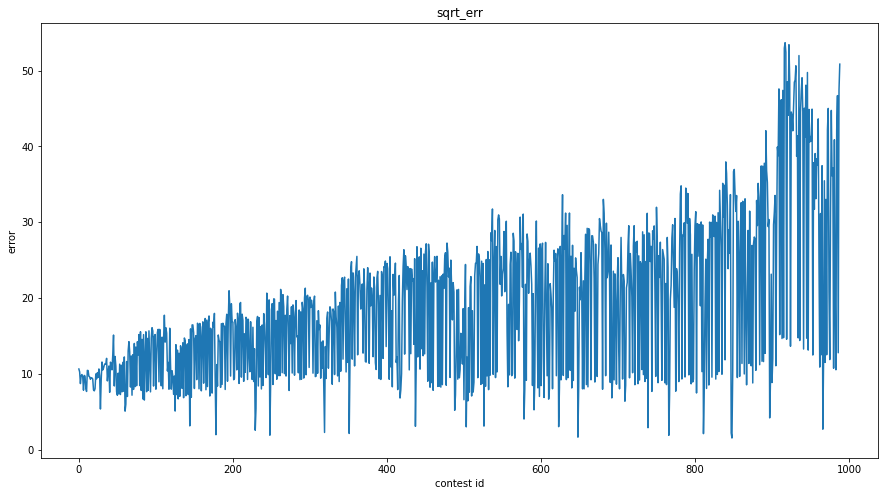

linear_err: 559.332211029261 mean +- 300.2401208222442 stdev


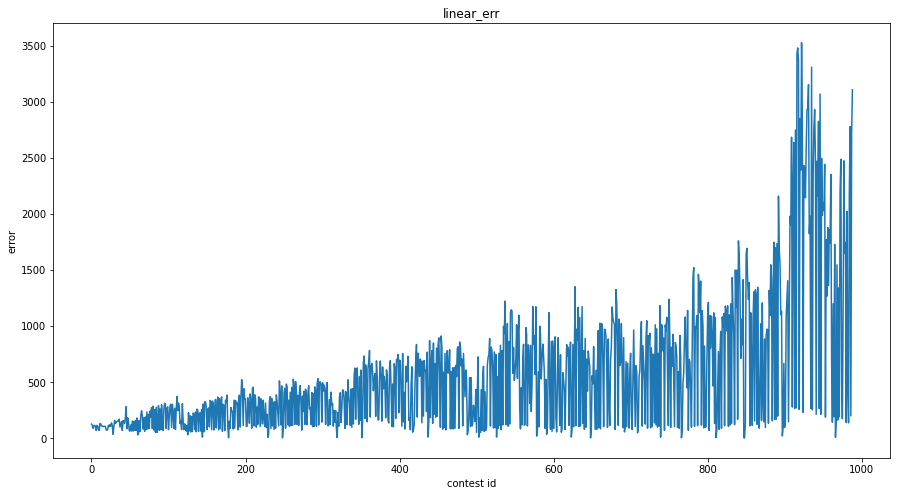

log_err: 0.616124394795445 mean +- 0.0519377085994992 stdev


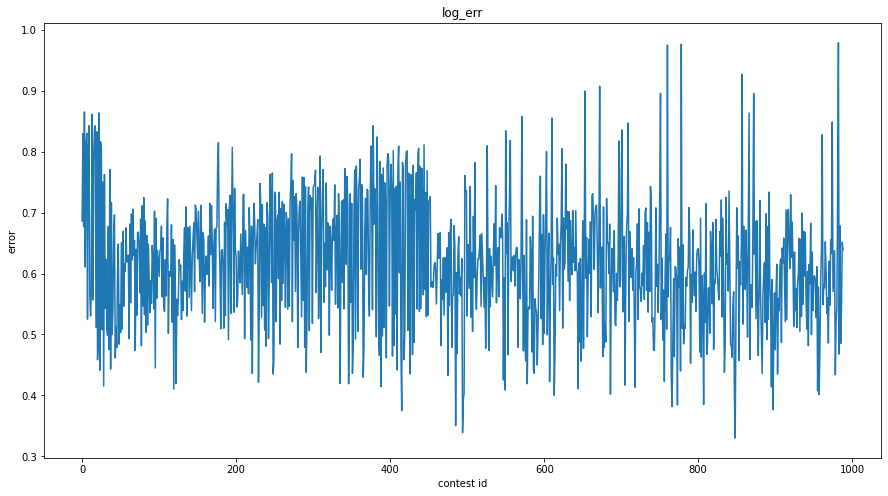

In [175]:
for err_fun_name in all_err_fun_names:
    errs = list(errors[err_fun_name].values())
    mean_err = np.mean(errs)
    std_err = np.std(errs)
    print(err_fun_name + ":", mean_err, "mean", "+-", std_err / 2, "stdev")
    
    plt.figure(figsize=(15, 8))
    plt.plot(errs)
    plt.xlabel("contest id")
    plt.ylabel("error")
    plt.title(err_fun_name)
    plt.show()

We have to mention that all the errors, except logarithmic, seem to increase with contests (from least recent to most recent). This is because CodeForces gained more users with time and all linear and square root errors are sensitive to number of users. But still we have to mention that logarithmic error does not have that problem and that is the error we will try to optimize as it is the most natural, when considering your future place in ranking - e.g. if your expected position in ranking for the next contest (considering other participants) is 1500, prediction interval [1300, 1700] seems reasonable, while if your expected position would be 300, interval [100, 500] seems like pretty bad prediction.

## Parameter influence on user rating shape

We have 5 parameters for AtCoder rating system. Let's see what they influence.

In [21]:
def get_ratings(self, handle):
    handle_id = self.handle_to_id[handle]
    contest_cnt = self.user_contest_cnt[handle_id]
    user_offset = self.offsets[handle_id]
    assert contest_cnt == self.local_offsets[handle_id]

    perfs = self.perfs[user_offset:user_offset+contest_cnt]
    atcoder_ratings = self.ratings[user_offset:user_offset+contest_cnt]
    cf_ratings = self.get_cf_ratings(handle)
    xs = np.arange(contest_cnt)
    
    return xs, atcoder_ratings, cf_ratings

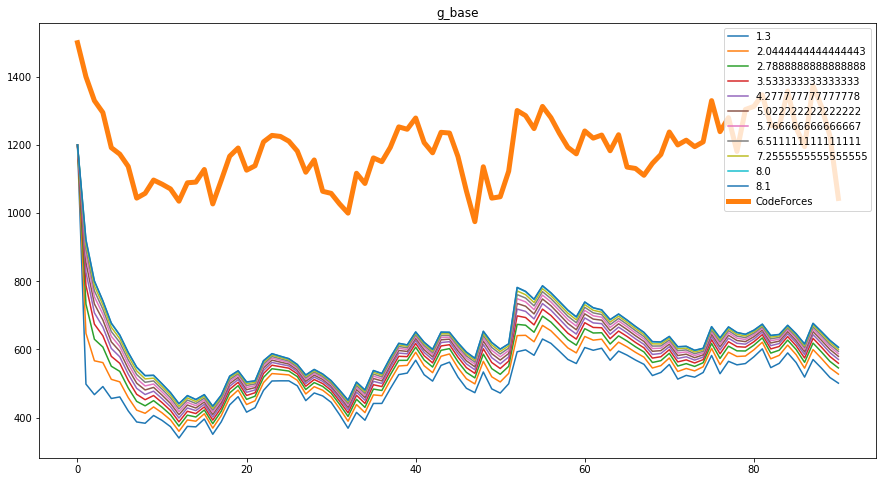

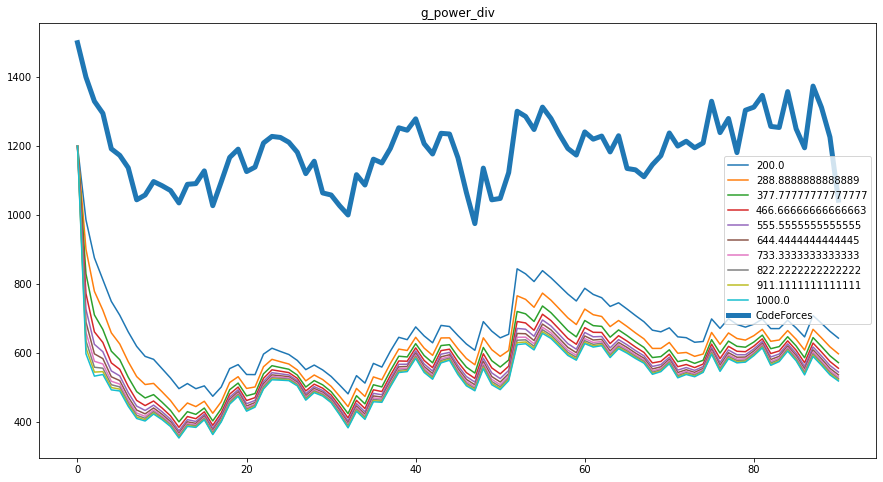

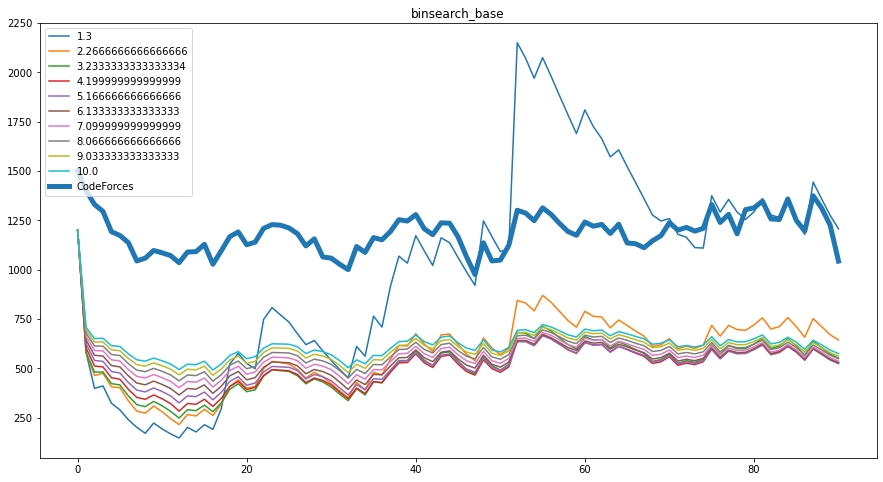

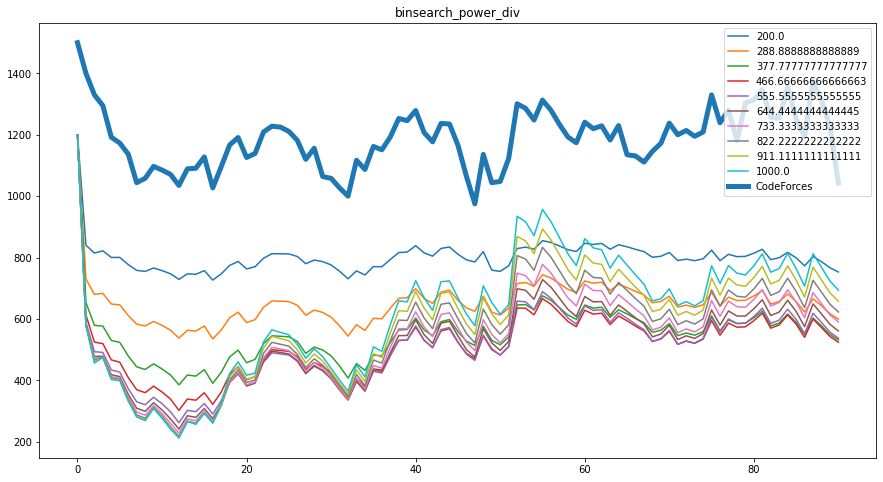

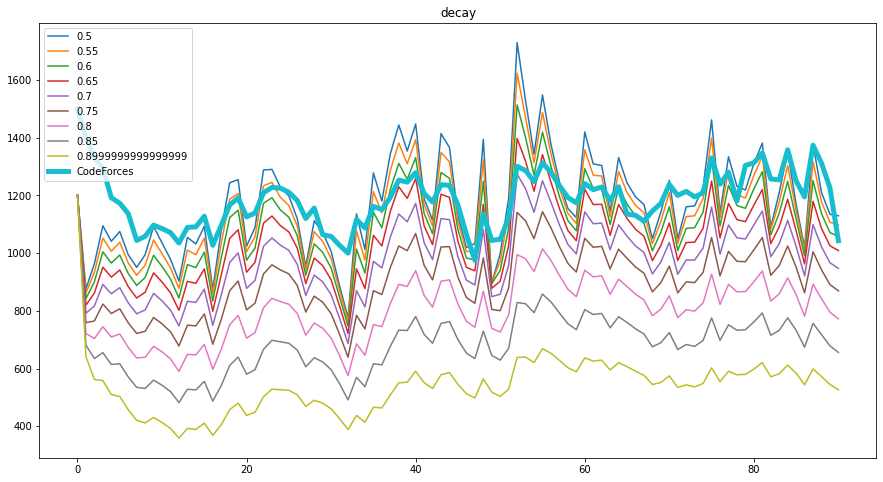

In [24]:
handle = all_results["g_base"][1.3][1].get_random_user(threshold=50)
for param_name, results in all_results.items():
    plt.figure(figsize=(15, 8))
    for value, (_, result) in results.items():
        xs, atcoder_ratings, cf_ratings = get_ratings(result, handle)
        plt.plot(xs, atcoder_ratings, label=str(value))
    plt.plot(xs, cf_ratings, label="CodeForces", linewidth=5)
    plt.title(param_name)
    plt.legend()
    plt.show()

## Finding optimal parameters

We are trying to find the best parameters for AtCoder rating system in order to minimize error.

### Individual parameter influence calculations

We will be analyzing, how individual parameter change influences error rate.

In [181]:
g_bases = np.linspace(1.3, 13, 10)
# g_bases = np.linspace(8.1, 13, 3)
g_power_divs = np.linspace(2, 1500, 10)
# g_power_divs = np.linspace(1100, 1500, 3)
binsearch_bases = np.linspace(1.3, 13, 10)
# binsearch_bases = np.linspace(10.5, 13, 3)
binsearch_power_divs = np.linspace(200, 1500, 10)
# binsearch_power_divs = np.linspace(1100, 1500, 3)
decays = np.linspace(0.5, 0.99, 10)
# decays = np.linspace(0.95, 0.99, 3)

mult = len(g_bases) + len(g_power_divs) + len(binsearch_bases) + len(binsearch_power_divs) + len(decays)
one_instance = 4 * 60 + 7
all_instances = one_instance * mult
print("Estimated time: %02dh %02dm %02.2fs" % (all_instances // 3600, all_instances % 3600 // 60, all_instances % 60))

Estimated time: 03h 25m 50.00s


In [183]:
consider = 500
save_file = f"save{consider}.pickle"

if os.path.exists(save_file):
    print("Loading file in ...")
    with open(save_file, "rb") as infile:
        all_results = pickle.load(infile)
    print("File loaded.")
else:
    all_results = {
        "g_base": {},
        "g_power_div": {},
        "binsearch_base": {},
        "binsearch_power_div": {},
        "decay": {}
    }

# all_results["g_base"][1.3]["linear_err"] gives contest id -> error mapping

Loading file in ...
File loaded.


In [184]:
for g_base in g_bases:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=all_err_funs,
        g_base=g_base, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["g_base"][g_base] = errors
    
with open(save_file, "wb") as outfile:
    pickle.dump(all_results, outfile)

Standings left: 500
Standings left: 499
Standings left: 498
Standings left: 497
Standings left: 496
Standings left: 495
Standings left: 494
Standings left: 493
Standings left: 492
Standings left: 491
Standings left: 490
Standings left: 489
Standings left: 488
Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451


Standings left: 84
Standings left: 83
Standings left: 82
Standings left: 81
Standings left: 80
Standings left: 79
Standings left: 78
Standings left: 77
Standings left: 76
Standings left: 75
Standings left: 74
Standings left: 73
Standings left: 72
Standings left: 71
Standings left: 70
Standings left: 69
Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings le

Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116


Standings left: 246
Standings left: 245
Standings left: 244
Standings left: 243
Standings left: 242
Standings left: 241
Standings left: 240
Standings left: 239
Standings left: 238
Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197


Standings left: 328
Standings left: 327
Standings left: 326
Standings left: 325
Standings left: 324
Standings left: 323
Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279


Standings left: 413
Standings left: 412
Standings left: 411
Standings left: 410
Standings left: 409
Standings left: 408
Standings left: 407
Standings left: 406
Standings left: 405
Standings left: 404
Standings left: 403
Standings left: 402
Standings left: 401
Standings left: 400
Standings left: 399
Standings left: 398
Standings left: 397
Standings left: 396
Standings left: 395
Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364


Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438
Standings left: 437
Standings left: 436
Standings left: 435
Standings left: 434


Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings le

Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104


Standings left: 239
Standings left: 238
Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197
Standings left: 196
Standings left: 195
Standings left: 194
Standings left: 193
Standings left: 192
Standings left: 191
Standings left: 190


Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273
Standings left: 272
Standings left: 271
Standings left: 270
Standings left: 269
Standings left: 268
Standings left: 267
Standings left: 266


Standings left: 398
Standings left: 397
Standings left: 396
Standings left: 395
Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364
Standings left: 363
Standings left: 362
Standings left: 361
Standings left: 360
Standings left: 359
Standings left: 358
Standings left: 357
Standings left: 356
Standings left: 355
Standings left: 354
Standings left: 353
Standings left: 352
Standings left: 351
Standings left: 350
Standings left: 349


In [187]:
for g_power_div in g_power_divs:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=all_err_funs,
        g_base=2, g_power_div=g_power_div, binsearch_base=6, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["g_power_div"][g_power_div] = errors
    
with open(save_file, "wb") as outfile:
    pickle.dump(all_results, outfile)

Standings left: 500
Standings left: 499
Standings left: 498
Standings left: 497
Standings left: 496
Standings left: 495
Standings left: 494
Standings left: 493
Standings left: 492
Standings left: 491
Standings left: 490
Standings left: 489
Standings left: 488
Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451


Standings left: 88
Standings left: 87
Standings left: 86
Standings left: 85
Standings left: 84
Standings left: 83
Standings left: 82
Standings left: 81
Standings left: 80
Standings left: 79
Standings left: 78
Standings left: 77
Standings left: 76
Standings left: 75
Standings left: 74
Standings left: 73
Standings left: 72
Standings left: 71
Standings left: 70
Standings left: 69
Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings le

Standings left: 168
Standings left: 167
Standings left: 166
Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119


Standings left: 253
Standings left: 252
Standings left: 251
Standings left: 250
Standings left: 249
Standings left: 248
Standings left: 247
Standings left: 246
Standings left: 245
Standings left: 244
Standings left: 243
Standings left: 242
Standings left: 241
Standings left: 240
Standings left: 239
Standings left: 238
Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204


Standings left: 338
Standings left: 337
Standings left: 336
Standings left: 335
Standings left: 334
Standings left: 333
Standings left: 332
Standings left: 331
Standings left: 330
Standings left: 329
Standings left: 328
Standings left: 327
Standings left: 326
Standings left: 325
Standings left: 324
Standings left: 323
Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289


Standings left: 418
Standings left: 417
Standings left: 416
Standings left: 415
Standings left: 414
Standings left: 413
Standings left: 412
Standings left: 411
Standings left: 410
Standings left: 409
Standings left: 408
Standings left: 407
Standings left: 406
Standings left: 405
Standings left: 404
Standings left: 403
Standings left: 402
Standings left: 401
Standings left: 400
Standings left: 399
Standings left: 398
Standings left: 397
Standings left: 396
Standings left: 395
Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369


Standings left: 2
Standings left: 1
Calculated in 00m 41.27s
Standings left: 500
Standings left: 499
Standings left: 498
Standings left: 497
Standings left: 496
Standings left: 495
Standings left: 494
Standings left: 493
Standings left: 492
Standings left: 491
Standings left: 490
Standings left: 489
Standings left: 488
Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454

Standings left: 91
Standings left: 90
Standings left: 89
Standings left: 88
Standings left: 87
Standings left: 86
Standings left: 85
Standings left: 84
Standings left: 83
Standings left: 82
Standings left: 81
Standings left: 80
Standings left: 79
Standings left: 78
Standings left: 77
Standings left: 76
Standings left: 75
Standings left: 74
Standings left: 73
Standings left: 72
Standings left: 71
Standings left: 70
Standings left: 69
Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings le

Standings left: 176
Standings left: 175
Standings left: 174
Standings left: 173
Standings left: 172
Standings left: 171
Standings left: 170
Standings left: 169
Standings left: 168
Standings left: 167
Standings left: 166
Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127


Standings left: 259
Standings left: 258
Standings left: 257
Standings left: 256
Standings left: 255
Standings left: 254
Standings left: 253
Standings left: 252
Standings left: 251
Standings left: 250
Standings left: 249
Standings left: 248
Standings left: 247
Standings left: 246
Standings left: 245
Standings left: 244
Standings left: 243
Standings left: 242
Standings left: 241
Standings left: 240
Standings left: 239
Standings left: 238
Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210


Standings left: 344
Standings left: 343
Standings left: 342
Standings left: 341
Standings left: 340
Standings left: 339
Standings left: 338
Standings left: 337
Standings left: 336
Standings left: 335
Standings left: 334
Standings left: 333
Standings left: 332
Standings left: 331
Standings left: 330
Standings left: 329
Standings left: 328
Standings left: 327
Standings left: 326
Standings left: 325
Standings left: 324
Standings left: 323
Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295


Standings left: 427
Standings left: 426
Standings left: 425
Standings left: 424
Standings left: 423
Standings left: 422
Standings left: 421
Standings left: 420
Standings left: 419
Standings left: 418
Standings left: 417
Standings left: 416
Standings left: 415
Standings left: 414
Standings left: 413
Standings left: 412
Standings left: 411
Standings left: 410
Standings left: 409
Standings left: 408
Standings left: 407
Standings left: 406
Standings left: 405
Standings left: 404
Standings left: 403
Standings left: 402
Standings left: 401
Standings left: 400
Standings left: 399
Standings left: 398
Standings left: 397
Standings left: 396
Standings left: 395
Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378


Standings left: 8
Standings left: 7
Standings left: 6
Standings left: 5
Standings left: 4
Standings left: 3
Standings left: 2
Standings left: 1
Calculated in 00m 41.55s


In [188]:
for binsearch_base in binsearch_bases:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=all_err_funs,
        g_base=2, g_power_div=800, binsearch_base=binsearch_base, binsearch_power_div=400, decay=0.9,
        consider=consider, verbose=True)
    all_results["binsearch_base"][binsearch_base] = errors
    
with open(save_file, "wb") as outfile:
    pickle.dump(all_results, outfile)

Standings left: 500
Standings left: 499
Standings left: 498
Standings left: 497
Standings left: 496
Standings left: 495
Standings left: 494
Standings left: 493
Standings left: 492
Standings left: 491
Standings left: 490
Standings left: 489
Standings left: 488
Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451


Standings left: 84
Standings left: 83
Standings left: 82
Standings left: 81
Standings left: 80
Standings left: 79
Standings left: 78
Standings left: 77
Standings left: 76
Standings left: 75
Standings left: 74
Standings left: 73
Standings left: 72
Standings left: 71
Standings left: 70
Standings left: 69
Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings le

Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116


Standings left: 248
Standings left: 247
Standings left: 246
Standings left: 245
Standings left: 244
Standings left: 243
Standings left: 242
Standings left: 241
Standings left: 240
Standings left: 239
Standings left: 238
Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199


Standings left: 328
Standings left: 327
Standings left: 326
Standings left: 325
Standings left: 324
Standings left: 323
Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279


Standings left: 409
Standings left: 408
Standings left: 407
Standings left: 406
Standings left: 405
Standings left: 404
Standings left: 403
Standings left: 402
Standings left: 401
Standings left: 400
Standings left: 399
Standings left: 398
Standings left: 397
Standings left: 396
Standings left: 395
Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364
Standings left: 363
Standings left: 362
Standings left: 361
Standings left: 360


Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438
Standings left: 437
Standings left: 436
Standings left: 435
Standings left: 434
Standings left: 433
Standings left: 432


Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings left: 15
Standings left: 14
Standings le

Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104
Standings left: 103
Standings left: 102
Standings left: 101
Standings left: 100
Standings left: 99
Standings left: 98
St

Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197
Standings left: 196
Standings left: 195
Standings left: 194
Standings left: 193
Standings left: 192
Standings left: 191
Standings left: 190
Standings left: 189
Standings left: 188
Standings left: 187
Standings left: 186
Standings left: 185
Standings left: 184
Standings left: 183
Standings left: 182
Standings left: 181


Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273
Standings left: 272
Standings left: 271
Standings left: 270
Standings left: 269
Standings left: 268
Standings left: 267
Standings left: 266
Standings left: 265


Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364
Standings left: 363
Standings left: 362
Standings left: 361
Standings left: 360
Standings left: 359
Standings left: 358
Standings left: 357
Standings left: 356
Standings left: 355
Standings left: 354
Standings left: 353
Standings left: 352
Standings left: 351
Standings left: 350
Standings left: 349
Standings left: 348
Standings left: 347
Standings left: 346
Standings left: 345


In [189]:
for binsearch_power_div in binsearch_power_divs:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=all_err_funs,
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=binsearch_power_div, decay=0.9,
        consider=consider, verbose=True)
    all_results["binsearch_power_div"][binsearch_power_div] = errors
    
with open("save.pickle", "wb") as outfile:
    pickle.dump(all_results, outfile)

Standings left: 500
Standings left: 499
Standings left: 498
Standings left: 497
Standings left: 496
Standings left: 495
Standings left: 494
Standings left: 493
Standings left: 492
Standings left: 491
Standings left: 490
Standings left: 489
Standings left: 488
Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451


Standings left: 84
Standings left: 83
Standings left: 82
Standings left: 81
Standings left: 80
Standings left: 79
Standings left: 78
Standings left: 77
Standings left: 76
Standings left: 75
Standings left: 74
Standings left: 73
Standings left: 72
Standings left: 71
Standings left: 70
Standings left: 69
Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings le

Standings left: 168
Standings left: 167
Standings left: 166
Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119


Standings left: 246
Standings left: 245
Standings left: 244
Standings left: 243
Standings left: 242
Standings left: 241
Standings left: 240
Standings left: 239
Standings left: 238
Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197


Standings left: 330
Standings left: 329
Standings left: 328
Standings left: 327
Standings left: 326
Standings left: 325
Standings left: 324
Standings left: 323
Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281


Standings left: 412
Standings left: 411
Standings left: 410
Standings left: 409
Standings left: 408
Standings left: 407
Standings left: 406
Standings left: 405
Standings left: 404
Standings left: 403
Standings left: 402
Standings left: 401
Standings left: 400
Standings left: 399
Standings left: 398
Standings left: 397
Standings left: 396
Standings left: 395
Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364
Standings left: 363


Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438
Standings left: 437
Standings left: 436
Standings left: 435
Standings left: 434
Standings left: 433
Standings left: 432


Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings le

Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105
Standings left: 104
Standings left: 103
Standings left: 102
Standings left: 101


Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197
Standings left: 196
Standings left: 195
Standings left: 194
Standings left: 193
Standings left: 192
Standings left: 191
Standings left: 190
Standings left: 189
Standings left: 188
Standings left: 187
Standings left: 186
Standings left: 185
Standings left: 184
Standings left: 183
Standings left: 182


Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273
Standings left: 272
Standings left: 271
Standings left: 270
Standings left: 269
Standings left: 268
Standings left: 267
Standings left: 266
Standings left: 265
Standings left: 264
Standings left: 263
Standings left: 262
Standings left: 261


Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364
Standings left: 363
Standings left: 362
Standings left: 361
Standings left: 360
Standings left: 359
Standings left: 358
Standings left: 357
Standings left: 356
Standings left: 355
Standings left: 354
Standings left: 353
Standings left: 352
Standings left: 351
Standings left: 350
Standings left: 349
Standings left: 348
Standings left: 347
Standings left: 346
Standings left: 345


In [190]:
for decay in decays:
    errors, results = AtCoderRatingSystem(db, 
        err_fun=all_err_funs,
        g_base=2, g_power_div=800, binsearch_base=6, binsearch_power_div=400, decay=decay,
        consider=consider, verbose=True)
    all_results["decay"][decay] = errors
    
with open(save_file, "wb") as outfile:
    pickle.dump(all_results, outfile)

Standings left: 500
Standings left: 499
Standings left: 498
Standings left: 497
Standings left: 496
Standings left: 495
Standings left: 494
Standings left: 493
Standings left: 492
Standings left: 491
Standings left: 490
Standings left: 489
Standings left: 488
Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451


Standings left: 86
Standings left: 85
Standings left: 84
Standings left: 83
Standings left: 82
Standings left: 81
Standings left: 80
Standings left: 79
Standings left: 78
Standings left: 77
Standings left: 76
Standings left: 75
Standings left: 74
Standings left: 73
Standings left: 72
Standings left: 71
Standings left: 70
Standings left: 69
Standings left: 68
Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings le

Standings left: 166
Standings left: 165
Standings left: 164
Standings left: 163
Standings left: 162
Standings left: 161
Standings left: 160
Standings left: 159
Standings left: 158
Standings left: 157
Standings left: 156
Standings left: 155
Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117


Standings left: 246
Standings left: 245
Standings left: 244
Standings left: 243
Standings left: 242
Standings left: 241
Standings left: 240
Standings left: 239
Standings left: 238
Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197


Standings left: 328
Standings left: 327
Standings left: 326
Standings left: 325
Standings left: 324
Standings left: 323
Standings left: 322
Standings left: 321
Standings left: 320
Standings left: 319
Standings left: 318
Standings left: 317
Standings left: 316
Standings left: 315
Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279


Standings left: 413
Standings left: 412
Standings left: 411
Standings left: 410
Standings left: 409
Standings left: 408
Standings left: 407
Standings left: 406
Standings left: 405
Standings left: 404
Standings left: 403
Standings left: 402
Standings left: 401
Standings left: 400
Standings left: 399
Standings left: 398
Standings left: 397
Standings left: 396
Standings left: 395
Standings left: 394
Standings left: 393
Standings left: 392
Standings left: 391
Standings left: 390
Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364


Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
Standings left: 452
Standings left: 451
Standings left: 450
Standings left: 449
Standings left: 448
Standings left: 447
Standings left: 446
Standings left: 445
Standings left: 444
Standings left: 443
Standings left: 442
Standings left: 441
Standings left: 440
Standings left: 439
Standings left: 438
Standings left: 437
Standings left: 436
Standings left: 435


Standings left: 67
Standings left: 66
Standings left: 65
Standings left: 64
Standings left: 63
Standings left: 62
Standings left: 61
Standings left: 60
Standings left: 59
Standings left: 58
Standings left: 57
Standings left: 56
Standings left: 55
Standings left: 54
Standings left: 53
Standings left: 52
Standings left: 51
Standings left: 50
Standings left: 49
Standings left: 48
Standings left: 47
Standings left: 46
Standings left: 45
Standings left: 44
Standings left: 43
Standings left: 42
Standings left: 41
Standings left: 40
Standings left: 39
Standings left: 38
Standings left: 37
Standings left: 36
Standings left: 35
Standings left: 34
Standings left: 33
Standings left: 32
Standings left: 31
Standings left: 30
Standings left: 29
Standings left: 28
Standings left: 27
Standings left: 26
Standings left: 25
Standings left: 24
Standings left: 23
Standings left: 22
Standings left: 21
Standings left: 20
Standings left: 19
Standings left: 18
Standings left: 17
Standings left: 16
Standings le

Standings left: 154
Standings left: 153
Standings left: 152
Standings left: 151
Standings left: 150
Standings left: 149
Standings left: 148
Standings left: 147
Standings left: 146
Standings left: 145
Standings left: 144
Standings left: 143
Standings left: 142
Standings left: 141
Standings left: 140
Standings left: 139
Standings left: 138
Standings left: 137
Standings left: 136
Standings left: 135
Standings left: 134
Standings left: 133
Standings left: 132
Standings left: 131
Standings left: 130
Standings left: 129
Standings left: 128
Standings left: 127
Standings left: 126
Standings left: 125
Standings left: 124
Standings left: 123
Standings left: 122
Standings left: 121
Standings left: 120
Standings left: 119
Standings left: 118
Standings left: 117
Standings left: 116
Standings left: 115
Standings left: 114
Standings left: 113
Standings left: 112
Standings left: 111
Standings left: 110
Standings left: 109
Standings left: 108
Standings left: 107
Standings left: 106
Standings left: 105


Standings left: 237
Standings left: 236
Standings left: 235
Standings left: 234
Standings left: 233
Standings left: 232
Standings left: 231
Standings left: 230
Standings left: 229
Standings left: 228
Standings left: 227
Standings left: 226
Standings left: 225
Standings left: 224
Standings left: 223
Standings left: 222
Standings left: 221
Standings left: 220
Standings left: 219
Standings left: 218
Standings left: 217
Standings left: 216
Standings left: 215
Standings left: 214
Standings left: 213
Standings left: 212
Standings left: 211
Standings left: 210
Standings left: 209
Standings left: 208
Standings left: 207
Standings left: 206
Standings left: 205
Standings left: 204
Standings left: 203
Standings left: 202
Standings left: 201
Standings left: 200
Standings left: 199
Standings left: 198
Standings left: 197
Standings left: 196
Standings left: 195
Standings left: 194
Standings left: 193
Standings left: 192
Standings left: 191
Standings left: 190
Standings left: 189
Standings left: 188


Standings left: 314
Standings left: 313
Standings left: 312
Standings left: 311
Standings left: 310
Standings left: 309
Standings left: 308
Standings left: 307
Standings left: 306
Standings left: 305
Standings left: 304
Standings left: 303
Standings left: 302
Standings left: 301
Standings left: 300
Standings left: 299
Standings left: 298
Standings left: 297
Standings left: 296
Standings left: 295
Standings left: 294
Standings left: 293
Standings left: 292
Standings left: 291
Standings left: 290
Standings left: 289
Standings left: 288
Standings left: 287
Standings left: 286
Standings left: 285
Standings left: 284
Standings left: 283
Standings left: 282
Standings left: 281
Standings left: 280
Standings left: 279
Standings left: 278
Standings left: 277
Standings left: 276
Standings left: 275
Standings left: 274
Standings left: 273
Standings left: 272
Standings left: 271
Standings left: 270
Standings left: 269
Standings left: 268
Standings left: 267
Standings left: 266
Standings left: 265


Standings left: 389
Standings left: 388
Standings left: 387
Standings left: 386
Standings left: 385
Standings left: 384
Standings left: 383
Standings left: 382
Standings left: 381
Standings left: 380
Standings left: 379
Standings left: 378
Standings left: 377
Standings left: 376
Standings left: 375
Standings left: 374
Standings left: 373
Standings left: 372
Standings left: 371
Standings left: 370
Standings left: 369
Standings left: 368
Standings left: 367
Standings left: 366
Standings left: 365
Standings left: 364
Standings left: 363
Standings left: 362
Standings left: 361
Standings left: 360
Standings left: 359
Standings left: 358
Standings left: 357
Standings left: 356
Standings left: 355
Standings left: 354
Standings left: 353
Standings left: 352
Standings left: 351
Standings left: 350
Standings left: 349
Standings left: 348
Standings left: 347
Standings left: 346
Standings left: 345
Standings left: 344
Standings left: 343
Standings left: 342
Standings left: 341
Standings left: 340


### Individual parameter influence plots

Plot mean errors and standard deviations from individual influences calculated above.

In [245]:
# helper function
def get_ys(results, err_name, f):
    ys = []
    for val, all_errors in sorted(results.items(), key=lambda x: x[0]):
        errors = all_errors[err_name]
        vals = list(errors.values())
        ys.append(f(vals))
    return ys

In [246]:
# calculate statistics
stats = {}
for param_name, results in all_results.items():
    xs = sorted(list(results.keys()))
    param_dict = {}
    for err_name in all_err_fun_names:
        mean_ys = get_ys(results, err_name, np.mean)
        std_ys = get_ys(results, err_name, np.std)
        param_dict[err_name] = (xs, mean_ys, std_ys)
    stats[param_name] = param_dict

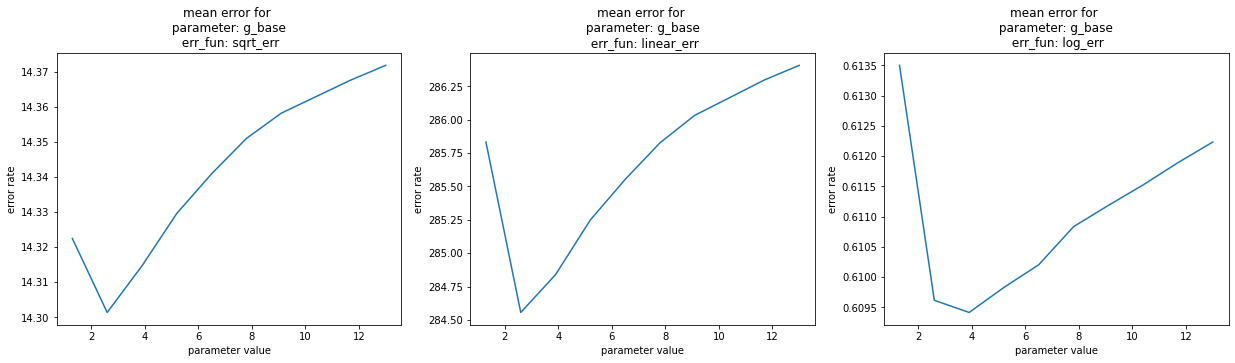

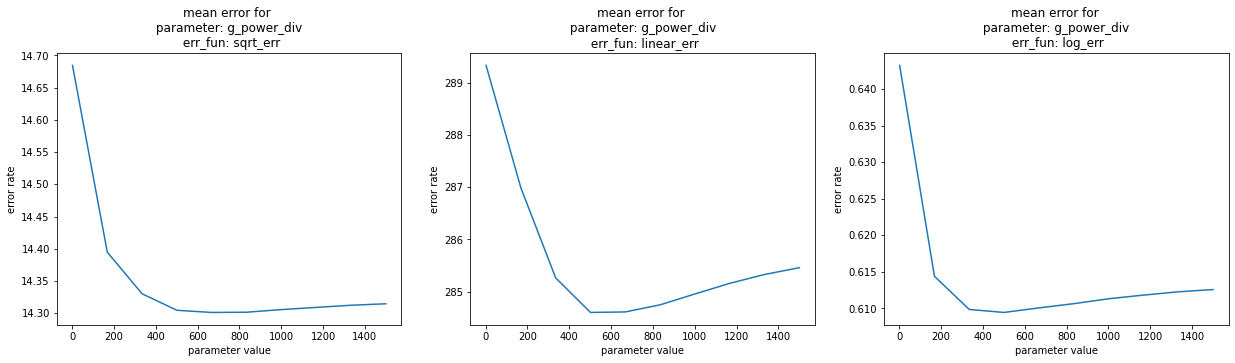

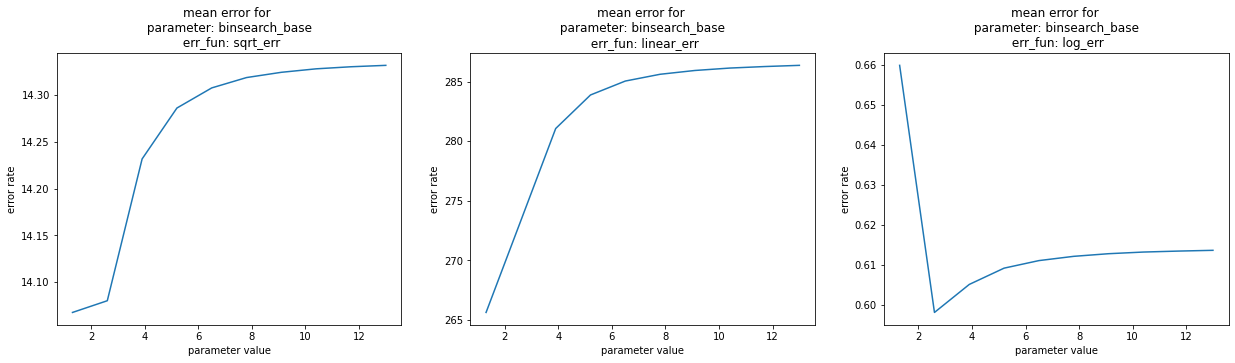

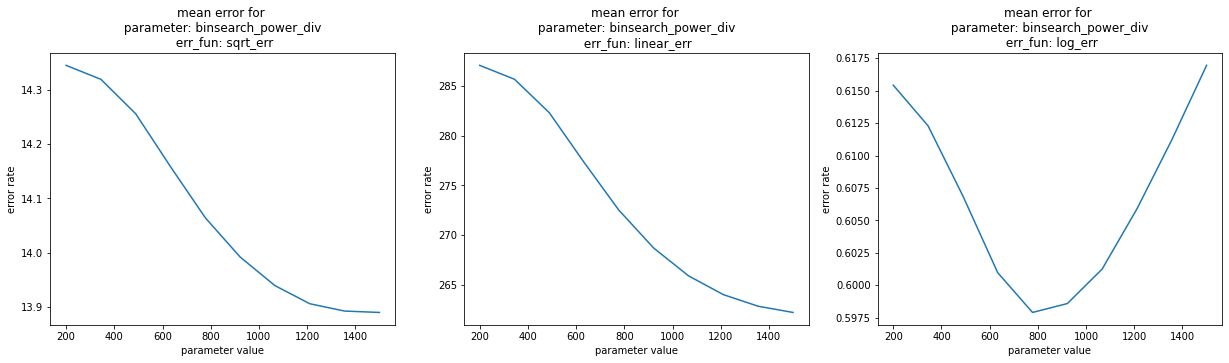

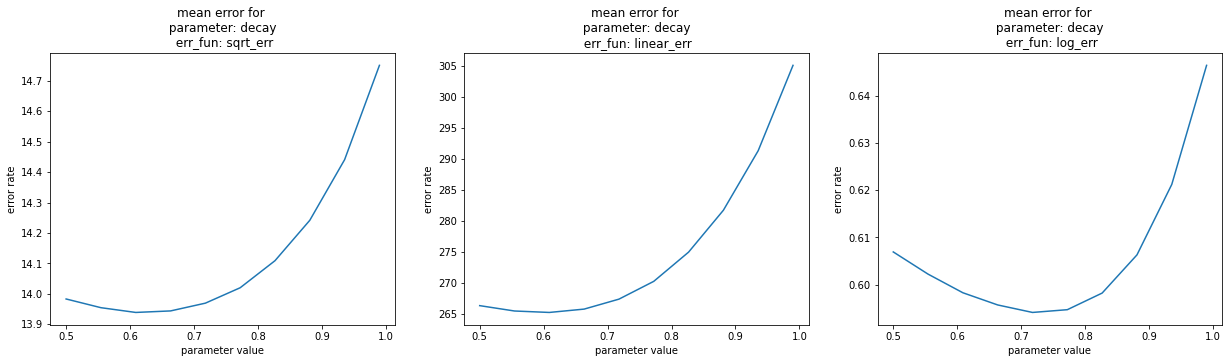

In [255]:
for param_name, param_dict in stats.items():
    fig, axs = plt.subplots(1, len(param_dict), figsize=(21, 5))
    for ax, (err_fun_name, (xs, mean_ys, std_ys)) in zip(axs, param_dict.items()):
        ax.title.set_text(f"mean error for \n parameter: {param_name} \n err_fun: {err_fun_name}")
        ax.set_xlabel("parameter value")
        ax.set_ylabel("error rate")
        ax.plot(xs, mean_ys)

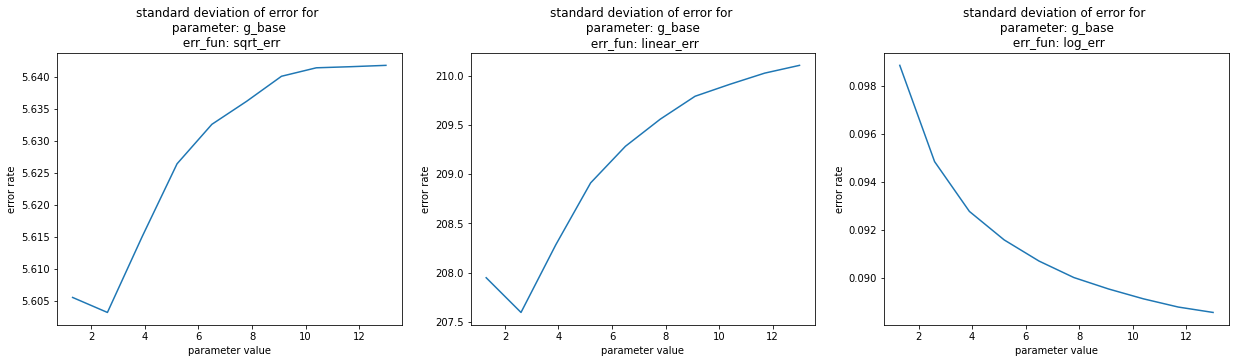

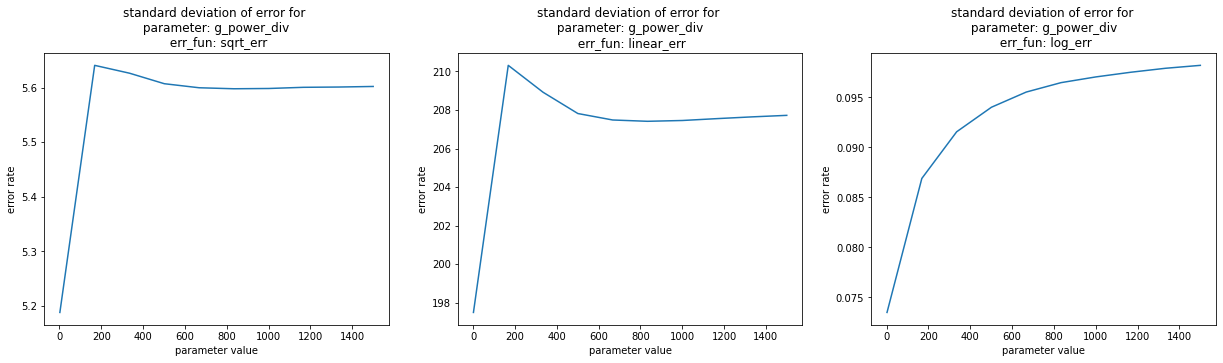

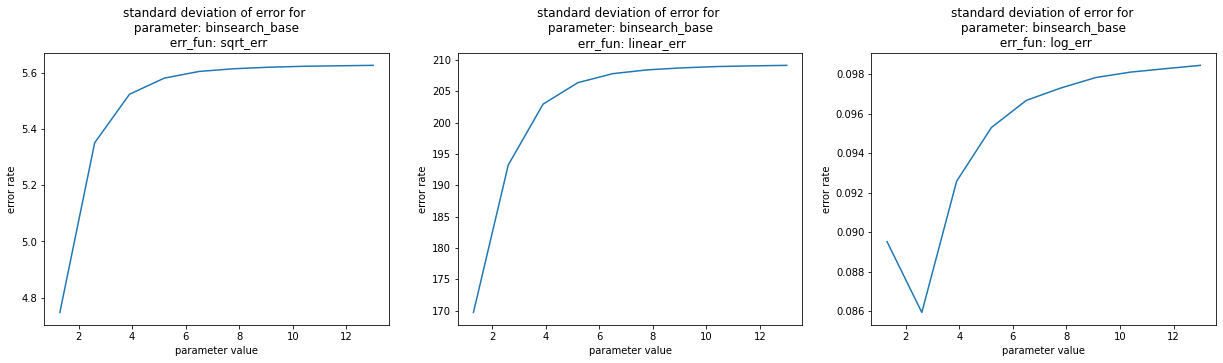

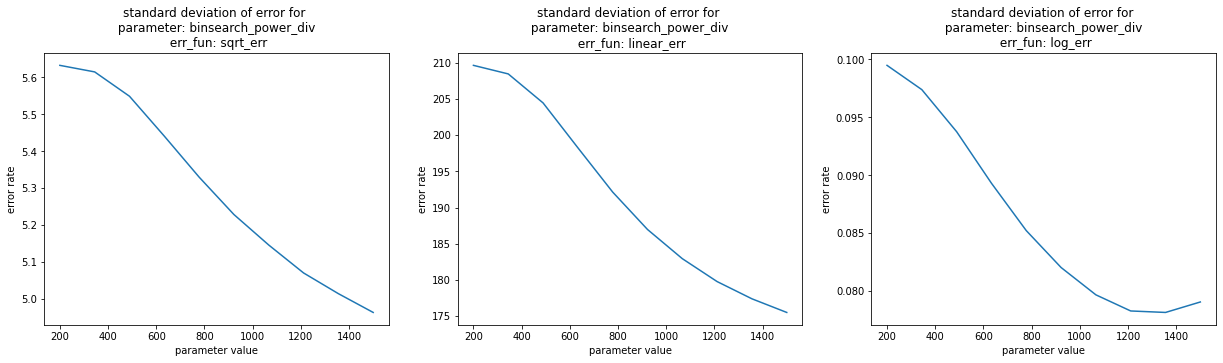

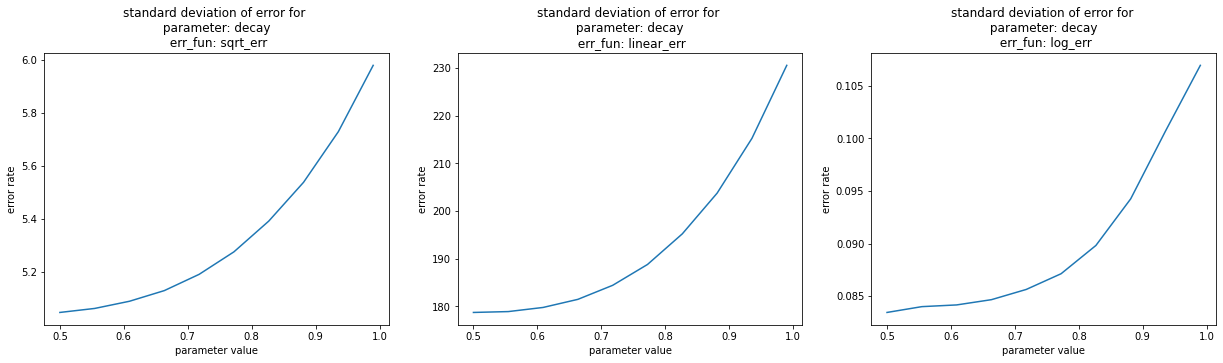

In [257]:
for param_name, param_dict in stats.items():
    fig, axs = plt.subplots(1, len(param_dict), figsize=(21, 5))
    for ax, (err_fun_name, (xs, mean_ys, std_ys)) in zip(axs, param_dict.items()):
        ax.title.set_text(f"standard deviation of error for \n parameter: {param_name} \n err_fun: {err_fun_name}")
        ax.set_xlabel("parameter value")
        ax.set_ylabel("error rate")
        ax.plot(xs, std_ys)

### Parameter space search

Search parameters space in more standarized way to find optimal parameters.

In [301]:
def get_eval(x, consider=500, err_fun_name="log_err"):
    errors, results = AtCoderRatingSystem(db, 
        err_fun=all_err_funs,
        g_base=x[0], g_power_div=x[1], binsearch_base=x[2], binsearch_power_div=x[3], decay=x[4],
        consider=consider, verbose=False)
    errs = list(errors[err_fun_name].values())
    return np.mean(errs)
    
def minimize(x0, eps, consider=500, err_fun_name="log_err", max_iters=100, verbose=False):
    param_cnt = len(x0)
    x = x0.copy()
    
    for i in range(max_iters):
        current_eval = get_eval(x, consider, err_fun_name)
        current_eps = np.zeros(param_cnt)

        if verbose:
            print("iteration:", i + 1, "current_eval:", current_eval, "x:", x)
        
        for i in range(param_cnt):
            delta = eps[i]
            x[i] += delta
            tmp_eval_inc = get_eval(x, consider, err_fun_name)
            x[i] -= 2 * delta
            tmp_eval_dec = get_eval(x, consider, err_fun_name)
            x[i] += delta
            if tmp_eval_inc < tmp_eval_dec:
                if tmp_eval_inc < current_eval:
                    current_eps[i] = delta
            else:
                if tmp_eval_dec < current_eval:
                    current_eps[i] = -delta
                    
        if np.any(current_eps != 0):
            x += current_eps
        else:
            break
            
    return x

In [303]:
x0 = np.array([2, 800, 6, 400, 0.71777])
# eps = np.array([0.05, 15, 0.1, 10, 0.01])
eps = np.array([0.2, 50, 0.5, 30, 0.1])
x_opt = minimize(x0, eps, verbose=True)

Calculated in 00m 38.96s
iteration: 1 current_eval: 0.594103311503783 x: [2.0000e+00 8.0000e+02 6.0000e+00 4.0000e+02 7.1777e-01]
Calculated in 00m 39.96s
Calculated in 00m 41.07s
Calculated in 00m 42.18s
Calculated in 00m 42.86s
Calculated in 00m 41.28s
Calculated in 00m 42.15s
Calculated in 00m 40.74s
Calculated in 00m 37.09s
Calculated in 00m 42.60s
Calculated in 00m 43.18s
Calculated in 00m 43.71s
iteration: 2 current_eval: 0.5935414901161317 x: [2.2000e+00 7.5000e+02 5.5000e+00 4.3000e+02 7.1777e-01]
Calculated in 00m 44.13s
Calculated in 00m 41.99s
Calculated in 00m 41.24s
Calculated in 00m 41.96s
Calculated in 00m 39.68s
Calculated in 00m 39.99s
Calculated in 00m 43.41s
Calculated in 00m 39.86s
Calculated in 00m 43.56s
Calculated in 00m 43.85s
Calculated in 00m 45.58s
iteration: 3 current_eval: 0.5933376192505184 x: [2.2000e+00 7.5000e+02 5.0000e+00 4.6000e+02 7.1777e-01]
Calculated in 00m 45.77s
Calculated in 00m 43.49s
Calculated in 00m 43.10s
Calculated in 00m 43.63s
Calculat

KeyboardInterrupt: 

Optimal vector found by parameter space search.

In [306]:
x_opt = [1.8, 850, 4.5, 490, 0.71777]
get_eval(x_opt, consider=500, err_fun_name="log_err")

Calculated in 00m 46.90s


0.5929381976141032

Check influence of individual parameters once again.

In [315]:
def parameter_influence(param_name, param_vals, consider, **kwargs):
    res = {}
    for param_val in param_vals:
        kwargs[param_name] = param_val
        errors, results = AtCoderRatingSystem(db,
            err_fun=all_err_funs,
            consider=consider,
            g_base=kwargs["g_base"],
            g_power_div=kwargs["g_power_div"],
            binsearch_base=kwargs["binsearch_base"],
            binsearch_power_div=kwargs["binsearch_power_div"],
            decay=kwargs["decay"])
        res[param_val] = errors
    return res

def plot_influence(param_name, influence, err_fun_name="log_err"):
    xs = list(influence.keys())
    ys = [np.mean(list(errors[err_fun_name].values())) for errors in influence.values()]
    plt.figure(figsize=(18, 5))
    plt.plot(xs, ys)
    plt.title(f"parameter {param_name} influence on error rate")
    plt.xlabel("parameter value")
    plt.ylabel("error rate")
    plt.show()
    
def get_opt_param_value(influence, err_fun_name="log_err"):
    param_vals = list(influence.keys())
    errors = [np.mean(list(errors[err_fun_name].values())) for errors in influence.values()]
    return param_vals[np.argmin(errors)]

#### binsearch_base influence

In [311]:
param_name = "binsearch_base"
binsearch_base_influence = parameter_influence(param_name, np.linspace(2, 6, 10), 500,
    g_base=x_opt[0], g_power_div=x_opt[1], binsearch_base=x_opt[2], binsearch_power_div=x_opt[3], decay=x_opt[4])

Calculated in 00m 40.84s
Calculated in 00m 43.11s
Calculated in 00m 42.38s
Calculated in 00m 43.77s
Calculated in 00m 43.05s
Calculated in 00m 42.80s
Calculated in 00m 43.45s
Calculated in 00m 43.41s
Calculated in 00m 38.17s
Calculated in 00m 43.93s


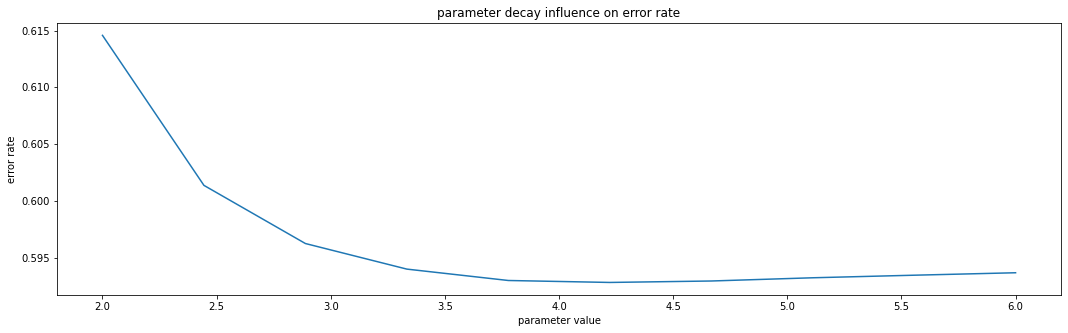

In [313]:
plot_influence(param_name, binsearch_base_influence)

In [316]:
get_opt_param_value(binsearch_base_influence)

4.222222222222222

In [317]:
x_opt = [1.8, 850, 4.2222, 490, 0.71777]

#### g_base influence

In [329]:
param_name = "g_base"
g_base_influence = parameter_influence(param_name, np.linspace(1.1, 2, 5), 500,
    g_base=x_opt[0], g_power_div=x_opt[1], binsearch_base=x_opt[2], binsearch_power_div=x_opt[3], decay=x_opt[4])

Calculated in 00m 45.08s
Calculated in 00m 42.02s
Calculated in 00m 41.43s
Calculated in 00m 42.48s
Calculated in 00m 38.76s


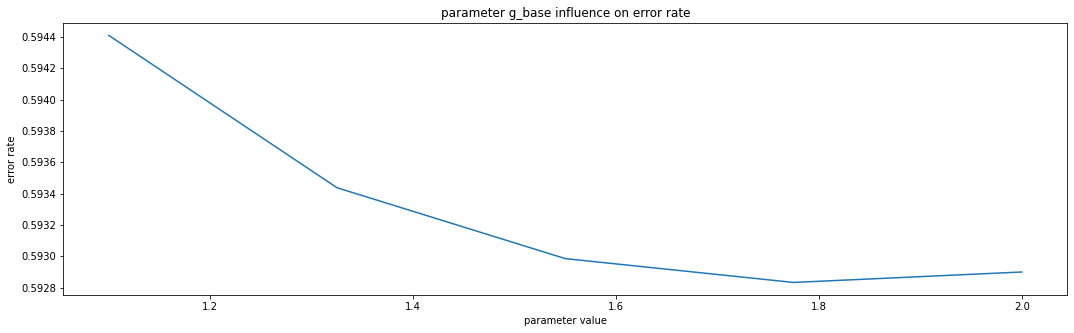

In [330]:
plot_influence(param_name, g_base_influence)

In [331]:
get_opt_param_value(g_base_influence)

1.775

In [333]:
x_opt[0] = 1.775

#### binsearch_power_div influence

In [334]:
param_name = "binsearch_power_div"
binsearch_power_div_influence = parameter_influence(param_name, np.linspace(200, 1000, 10), 500,
    g_base=x_opt[0], g_power_div=x_opt[1], binsearch_base=x_opt[2], binsearch_power_div=x_opt[3], decay=x_opt[4])

Calculated in 00m 36.24s
Calculated in 00m 37.70s
Calculated in 00m 40.68s
Calculated in 00m 41.91s
Calculated in 00m 41.48s
Calculated in 00m 38.78s
Calculated in 00m 42.17s
Calculated in 00m 38.59s
Calculated in 00m 43.04s
Calculated in 00m 41.15s


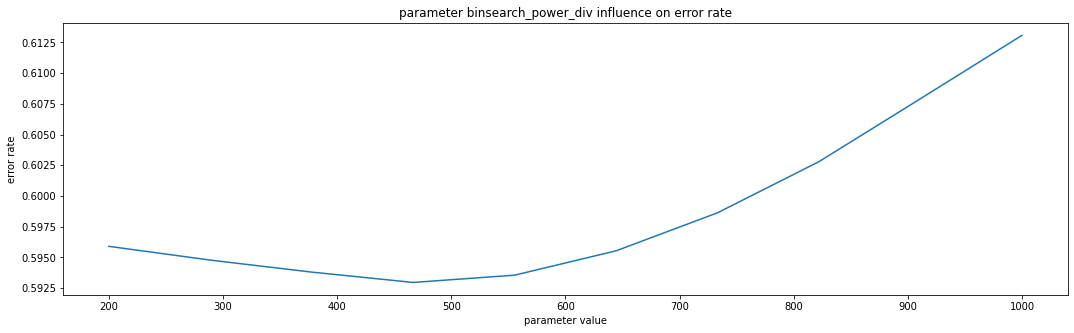

In [335]:
plot_influence(param_name, binsearch_power_div_influence)

In [336]:
get_opt_param_value(binsearch_power_div_influence)

466.66666666666663

In [337]:
x_opt[3] = 466.666

#### g_power_div influence

In [338]:
param_name = "g_power_div"
g_power_div_influence = parameter_influence(param_name, np.linspace(200, 1000, 10), 500,
    g_base=x_opt[0], g_power_div=x_opt[1], binsearch_base=x_opt[2], binsearch_power_div=x_opt[3], decay=x_opt[4])

Calculated in 00m 37.25s
Calculated in 00m 39.21s
Calculated in 00m 42.14s
Calculated in 00m 39.91s
Calculated in 00m 42.65s
Calculated in 00m 40.95s
Calculated in 00m 42.57s
Calculated in 00m 45.57s
Calculated in 00m 42.73s
Calculated in 00m 47.13s


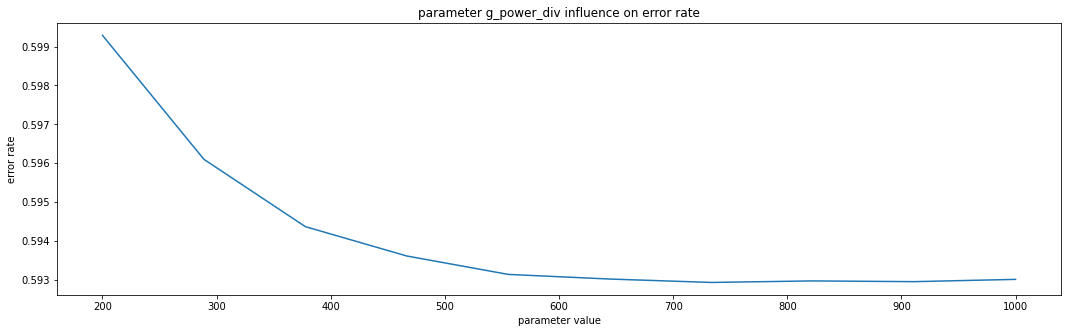

In [339]:
plot_influence(param_name, g_power_div_influence)

In [340]:
get_opt_param_value(g_power_div_influence)

733.3333333333333

In [341]:
x_opt[1] = 733.333

## Final result with optimized parameters

In [356]:
opt_errors, opt_results = AtCoderRatingSystem(db,
    err_fun=all_err_funs,
    consider=-1,
    g_base=x_opt[0],
    g_power_div=x_opt[1],
    binsearch_base=x_opt[2],
    binsearch_power_div=x_opt[3],
    decay=x_opt[4])

Calculated in 05m 33.12s


In [374]:
opt_error = np.mean(list(opt_errors["log_err"].values()))
opt_error

0.5535593754835577

In [357]:
errors, results = AtCoderRatingSystem(db,
    err_fun=all_err_funs,
    consider=-1,
    g_base=1.3,
    g_power_div=800,
    binsearch_base=6,
    binsearch_power_div=400,
    decay=0.95)

Calculated in 04m 50.43s


In [373]:
original_error = np.mean(list(errors["log_err"].values()))
original_error

0.6144284331065194

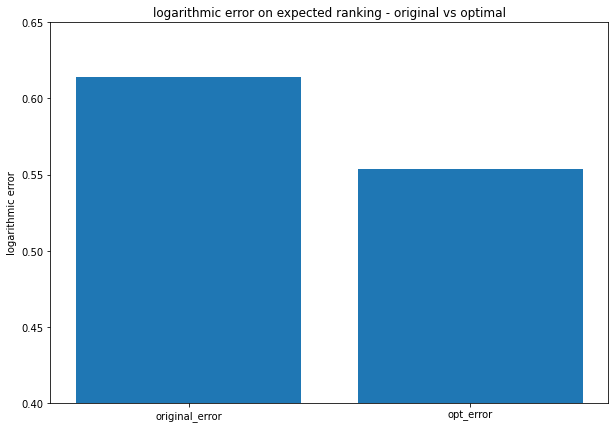

In [372]:
plt.figure(figsize=(10, 7))
plt.bar(["original_error", "opt_error"], [original_error, opt_error])
plt.ylim((0.4, 0.65))
plt.title("logarithmic error on expected ranking - original vs optimal")
plt.ylabel("logarithmic error")
plt.show()

## Conclusions

We have managed to find optimal parameters for AtCoder rating system, which reduced logarithmic error rate from  $\approx 0.62$ to $\approx 0.55$. Error rate difference for optimal parameters is not huge, but still it is visible.